# 신장 결석을 알아내는 모델을 만들어보자!

## 1. Library import 및 install

In [1]:
!pip install optuna
!pip install lazypredict

In [2]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

import optuna

from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from lightgbm.sklearn import LGBMClassifier
from lazypredict.Supervised import LazyClassifier
from sklearn.metrics import roc_auc_score

evaluation_metric=roc_auc_score
#이렇게 해두면 나중에 metric이 바뀔 때 이 뒤에만 수정해주면 됩니다.

from sklearn.model_selection import KFold
from functools import partial

### 1.1 Data import

이 데이터의 경우 원본 데이터가 있습니다. 이를 사용해서 모델의 성능을 높일 수 있을지도 모르므로 일단 데려와 봅니다.

In [3]:
original = pd.read_csv('./kindey stone urine analysis.csv')
train = pd.read_csv('./train.csv')
test = pd.read_csv('./test.csv')
sample_submission = pd.read_csv('./sample_submission.csv')

In [4]:
train.head() # id 제외하고 feature 는 6개. 알아맞혀야 하는 값은 target에 저장되어 있습니다.

,id,gravity,ph,osmo,cond,urea,calc,target
0,0,1.01,6.19,443,14.80,124,1.45,0
1,1,1.02,5.40,703,23.60,394,4.18,0
2,2,1.01,6.13,371,24.50,159,9.04,0
3,3,1.02,4.91,442,20.80,398,6.63,1
4,4,1.02,5.53,874,17.80,385,2.21,1


In [5]:
train.info() # 총 414개의 데이터가 있습니다. (아이고 작아라!) nan값은 없는 것으로 보입니다.

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 414 entries, 0 to 413
Data columns (total 8 columns):
 #   Column   Non-Null Count  Dtype  
---  ------   --------------  -----  
 0   id       414 non-null    int64  
 1   gravity  414 non-null    float64
 2   ph       414 non-null    float64
 3   osmo     414 non-null    int64  
 4   cond     414 non-null    float64
 5   urea     414 non-null    int64  
 6   calc     414 non-null    float64
 7   target   414 non-null    int64  
dtypes: float64(4), int64(4)
memory usage: 26.0 KB


In [6]:
train.describe()

,id,gravity,ph,osmo,cond,urea,calc,target
count,414.00,414.00,414.00,414.00,414.00,414.00,414.00,414.00
mean,206.50,1.02,5.96,651.55,21.44,278.66,4.11,0.44
std,119.66,0.01,0.64,234.68,7.51,136.44,3.22,0.50
min,0.00,1.00,4.76,187.00,5.10,10.00,0.17,0.00
25%,103.25,1.01,5.53,455.25,15.50,170.00,1.45,0.00
50%,206.50,1.02,5.74,679.50,22.20,277.00,3.13,0.00
75%,309.75,1.02,6.28,840.00,27.60,385.00,6.63,1.00
max,413.00,1.04,7.94,1236.00,38.00,620.00,14.34,1.00


In [7]:
original.describe() # 원본 데이터는 79명의 환자 데이터가 있습니다. id가 없습니다!

,gravity,ph,osmo,cond,urea,calc,target
count,79.00,79.00,79.00,79.00,79.00,79.00,79.00
mean,1.02,6.03,612.85,20.81,266.41,4.14,0.43
std,0.01,0.72,237.51,7.94,131.25,3.26,0.50
min,1.00,4.76,187.00,5.10,10.00,0.17,0.00
25%,1.01,5.53,413.00,14.15,160.00,1.46,0.00
50%,1.02,5.94,594.00,21.40,260.00,3.16,0.00
75%,1.02,6.38,792.00,26.55,372.00,5.93,1.00
max,1.04,7.94,1236.00,38.00,620.00,14.34,1.00


In [8]:
test.describe()

,id,gravity,ph,osmo,cond,urea,calc
count,276.00,276.00,276.00,276.00,276.00,276.00,276.00
mean,551.50,1.02,5.94,654.89,21.89,280.99,4.08
std,79.82,0.01,0.61,236.36,7.35,134.88,3.09
min,414.00,1.00,4.90,187.00,5.10,64.00,0.17
25%,482.75,1.01,5.53,456.00,17.40,168.50,1.53
50%,551.50,1.02,5.73,658.00,23.60,282.00,3.23
75%,620.25,1.02,6.21,843.25,27.60,385.00,5.54
max,689.00,1.03,7.94,1236.00,38.00,620.00,14.34


In [9]:
train.drop(columns=['id'], inplace=True)
test.drop(columns=['id'], inplace=True) # id는 의미 없는 값이므로 지워버립니다.

In [10]:
train_whole=pd.concat([train, original], axis=0, join='outer', ignore_index=True) #혹시 모르니까 전체 데이터도 한 번 만들어줍니다.

In [11]:
train_whole

,gravity,ph,osmo,cond,urea,calc,target
0,1.01,6.19,443,14.80,124,1.45,0
1,1.02,5.40,703,23.60,394,4.18,0
2,1.01,6.13,371,24.50,159,9.04,0
3,1.02,4.91,442,20.80,398,6.63,1
4,1.02,5.53,874,17.80,385,2.21,1
...,...,...,...,...,...,...,...
488,1.02,7.90,721,23.60,301,9.04,1
489,1.02,4.81,410,13.30,195,0.58,1
490,1.02,5.40,803,21.80,394,7.82,1
491,1.02,6.81,594,21.40,255,12.20,1


## 2. EDA

데이터가 어떻게 생겨먹었는지 확인해봅시다!

<Axes: xlabel='target', ylabel='count'>

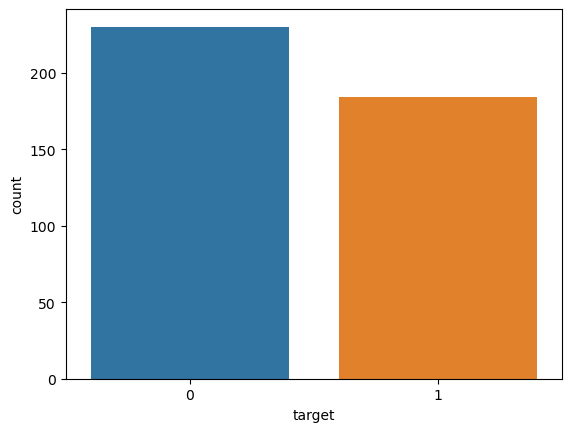

In [12]:
sns.countplot(data=train, x='target') 

<Axes: xlabel='target', ylabel='count'>

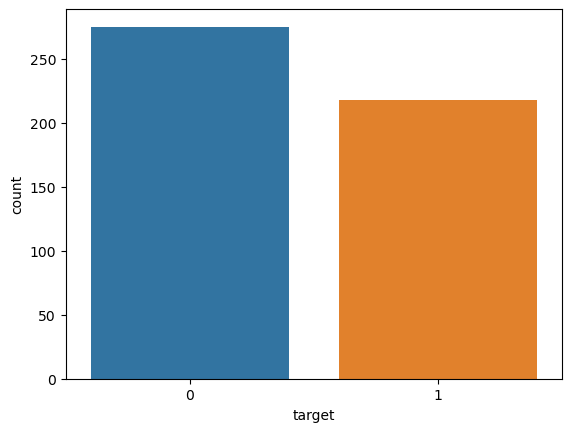

In [13]:
sns.countplot(data=train_whole, x='target') # 이정도면 나쁘지 않게 balanced 되어 있는 데이터입니다!

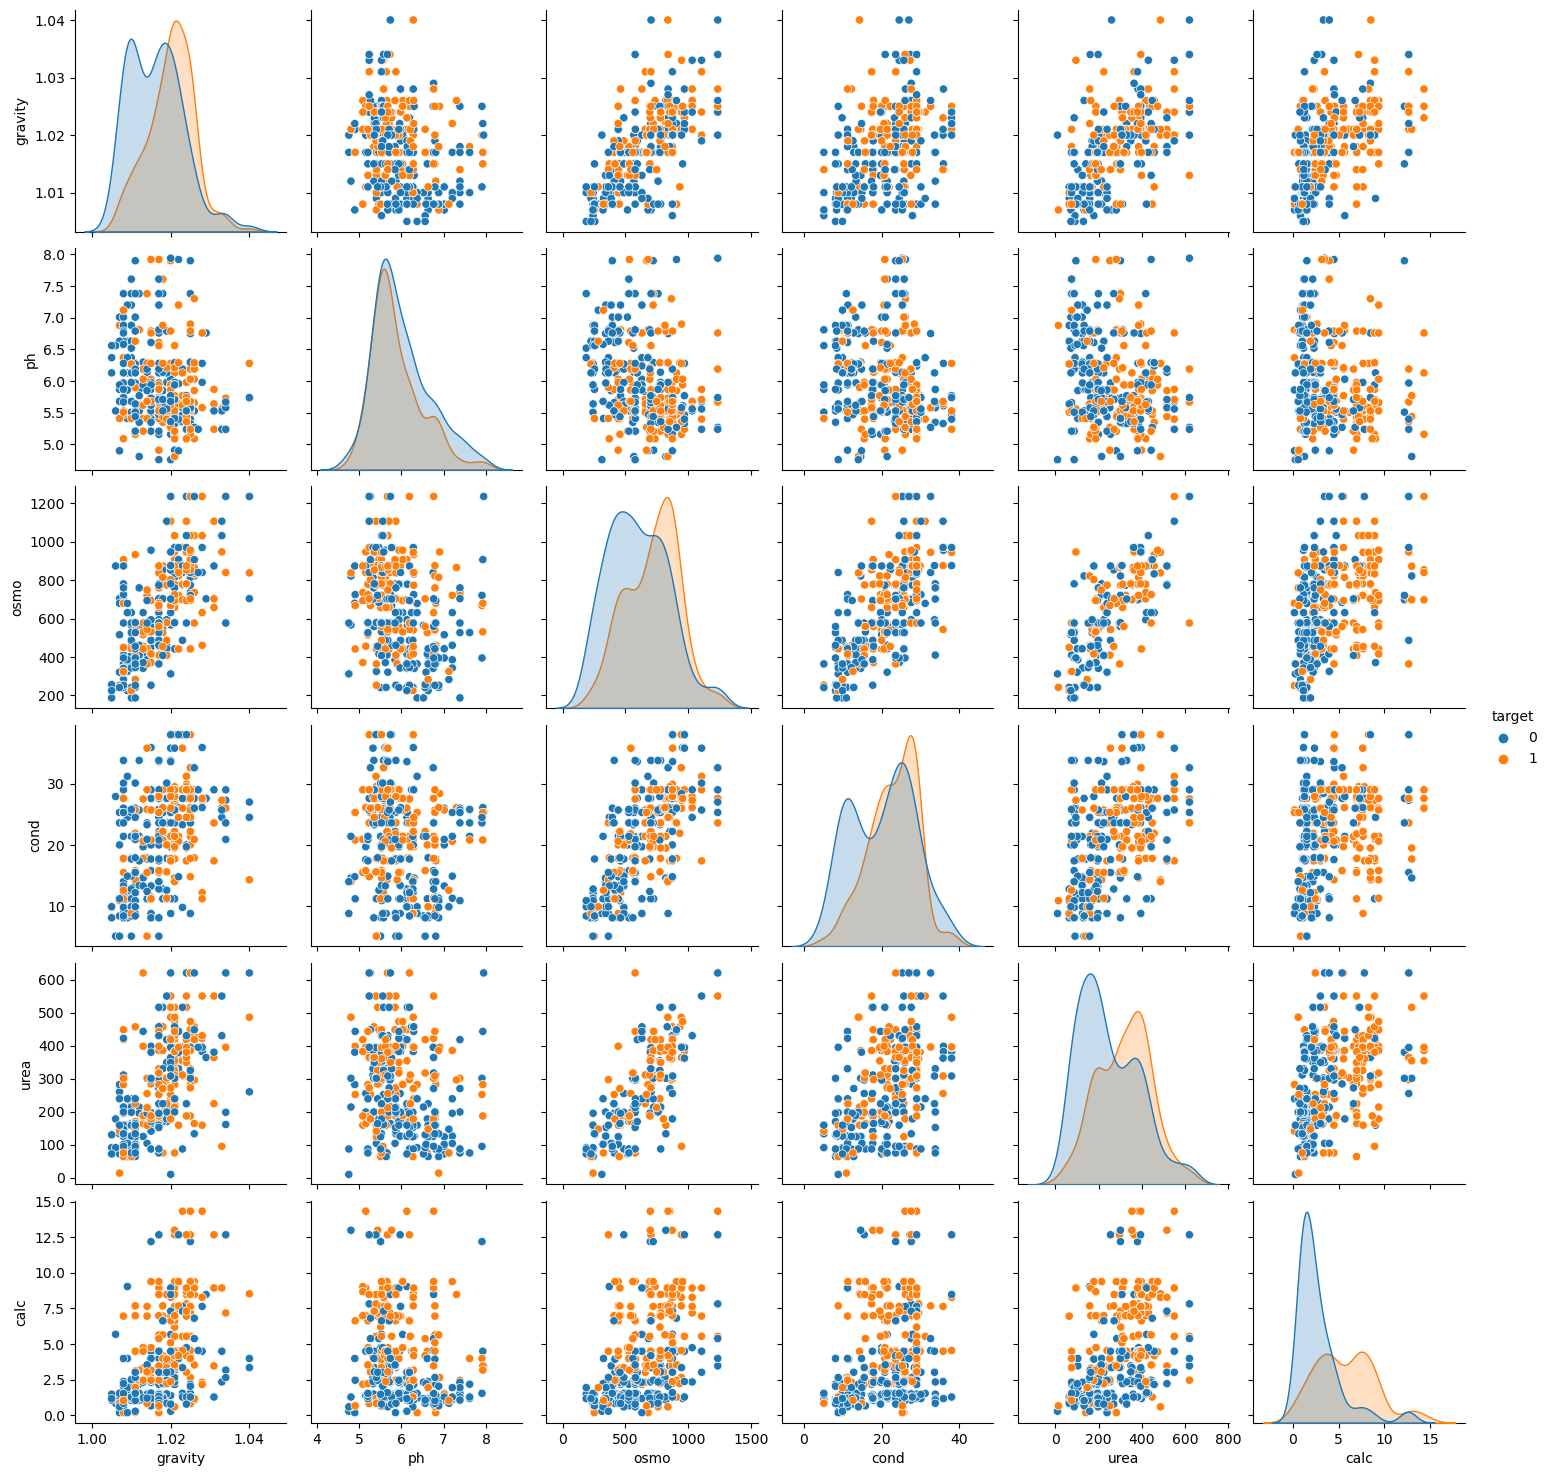

In [14]:
sns.pairplot(data=train, hue='target') # pH 는 분류를 하는데 그다지 도움이 되지 않을 것 같습니다.
# 이걸 날리면 오히려 연산이 빨라질까?

calc 는 잘 나누면 분류하는 데에 도움이 많이 될 것 같습니다.

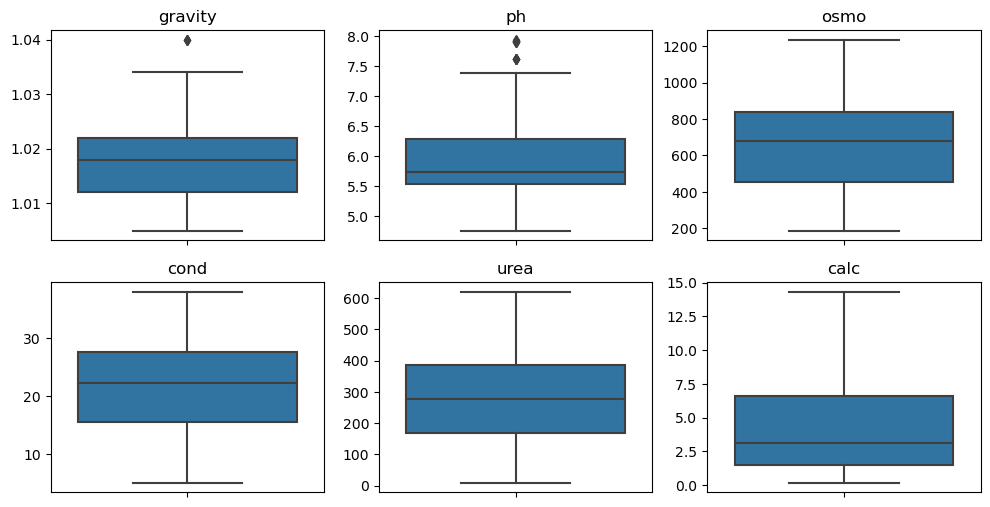

In [15]:
plt.figure(figsize=(12,6))
for i in range(6):
    plt.subplot(2,3,i+1)
    sns.boxplot(data=train, y=train.columns[i])
    plt.title(train.columns[i])
    plt.ylabel('')

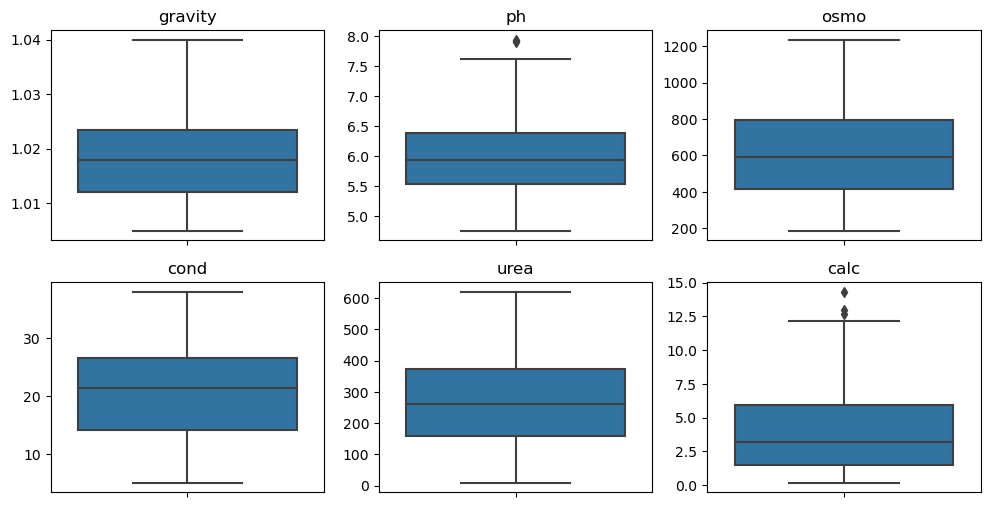

In [16]:
plt.figure(figsize=(12,6))
for i in range(6):
    plt.subplot(2,3,i+1)
    sns.boxplot(data=original, y=train.columns[i])
    plt.title(train.columns[i])
    plt.ylabel('')

<Axes: >

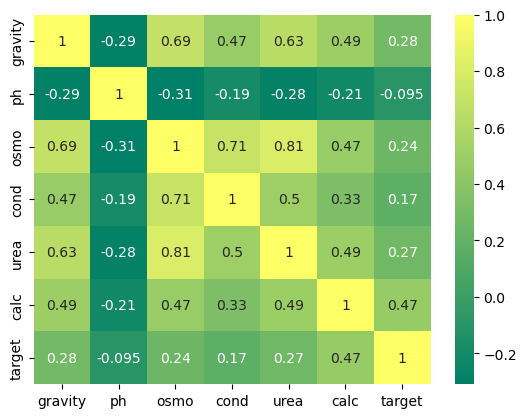

In [17]:
sns.heatmap(data=train.corr(), annot=True, cmap='summer')

calc 와 target 이 가장 큰 연관성을 가지고 있는 걸 알 수 있다. 

pH 는 유일하게 다른 모든 값들이랑 음의 상관관계를 갖는다.

In [18]:
train.ph.map(lambda x: 10**(-x))

0     0.00
1     0.00
2     0.00
3     0.00
4     0.00
      ... 
409   0.00
410   0.00
411   0.00
412   0.00
413   0.00
Name: ph, Length: 414, dtype: float64

In [19]:
train.ph>7 # is_alkali

0      False
1      False
2      False
3      False
4      False
       ...  
409    False
410    False
411    False
412     True
413    False
Name: ph, Length: 414, dtype: bool

## 3. 데이터 분리 - train_test_split

In [20]:
X = train.drop(columns=['target'])
y = train.target

In [21]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

In [22]:
param_grid = {
    'n_estimators' : 50,
    'max_depth' : 5,
    'n_jobs' : -1,
    'random_state' : 42,
}

model_RF = RandomForestClassifier(**param_grid)

In [23]:
model_RF.fit(X_train, y_train)

RandomForestClassifier(max_depth=5, n_estimators=50, n_jobs=-1, random_state=42)

In [24]:
print("Prediction")
pred_train = model_RF.predict_proba(X_train)[:,1]
pred_test = model_RF.predict_proba(X_test)[:,1]


train_score = evaluation_metric(y_train, pred_train)
test_score = evaluation_metric(y_test, pred_test)

print("Train Score : %.4f" % train_score)
print("Test Score : %.4f" % test_score)

Prediction
Train Score : 0.9358
Test Score : 0.8433


In [25]:
X = train_whole.drop('target', axis=1)
y = train_whole.target
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

In [26]:
model_RF.fit(X_train, y_train)

RandomForestClassifier(max_depth=5, n_estimators=50, n_jobs=-1, random_state=42)

In [27]:
print("Prediction")
pred_train = model_RF.predict_proba(X_train)[:,1]
pred_test = model_RF.predict_proba(X_test)[:,1]


train_score = evaluation_metric(y_train, pred_train)
test_score = evaluation_metric(y_test, pred_test)

print("Train Score : %.4f" % train_score)
print("Test Score : %.4f" % test_score)

Prediction
Train Score : 0.9274
Test Score : 0.8545


테스트 점수가 올라갔습니다!

In [28]:
param_grid={
    'n_estimators':15,
    'num_leaves':10,
    'min_child_samples':25,
    'max_depth':-1,
    'random_state':42,
}

model_LGBM = LGBMClassifier(**param_grid)

In [29]:
model_LGBM.fit(X_train, y_train)

LGBMClassifier(min_child_samples=25, n_estimators=15, num_leaves=10,
               random_state=42)

In [30]:
print("Prediction")
pred_train = model_LGBM.predict_proba(X_train)[:,1]
pred_test = model_LGBM.predict_proba(X_test)[:,1]


train_score = evaluation_metric(y_train, pred_train)
test_score = evaluation_metric(y_test, pred_test)

print("Train Score : %.4f" % train_score)
print("Test Score : %.4f" % test_score)

Prediction
Train Score : 0.8870
Test Score : 0.8726


In [31]:
from sklearn.model_selection import GridSearchCV

param_grid = {
    'n_estimators' : [200,300,500],
    'max_depth' : [10,20,30],
    'n_jobs' : [-1],
    'random_state' : [42],
    'min_samples_split' : [7,10,20],
    'min_samples_leaf' : [1],

}

model_RF = RandomForestClassifier(**param_grid)

gcv_RF = GridSearchCV(estimator=model_RF, param_grid=param_grid, cv=5,
                  n_jobs=-1, verbose=1, scoring='roc_auc')

gcv_RF.fit(X_train, y_train)
print("Best Estimator : ", gcv_RF.best_estimator_)

Fitting 5 folds for each of 27 candidates, totalling 135 fits
Best Estimator :  RandomForestClassifier(max_depth=20, min_samples_split=10, n_estimators=200,
                       n_jobs=-1, random_state=42)


In [32]:
gcv_RF.best_params_

{'max_depth': 20,
 'min_samples_leaf': 1,
 'min_samples_split': 10,
 'n_estimators': 200,
 'n_jobs': -1,
 'random_state': 42}

In [33]:
print("Prediction with Best Estimator")
gcv_pred_train = gcv_RF.predict_proba(X_train)[:,1]
gcv_pred_val = gcv_RF.predict_proba(X_test)[:,1]

gcv_train_score = evaluation_metric(y_train, gcv_pred_train)
gcv_val_score = evaluation_metric(y_test, gcv_pred_val)

print("Train acc Score : %.4f" % gcv_train_score)
print("Test acc Score : %.4f" % gcv_val_score)

Prediction with Best Estimator
Train acc Score : 0.9816
Test acc Score : 0.8532


In [34]:
param_grid={
    'n_estimators':[15,5,30],
    'num_leaves':[10,5,20,30],
    'min_child_samples':[10,25,50],
    'max_depth':[-1,2,4,7,15],
    'random_state':[42],
}

model_LGBM = LGBMClassifier(**param_grid)

gcv_LGBM = GridSearchCV(estimator=model_LGBM, param_grid=param_grid, cv=5,
                  n_jobs=-1, verbose=1, scoring='roc_auc')

gcv_LGBM.fit(X_train, y_train)
print("Best Estimator : ", gcv_LGBM.best_estimator_)

Fitting 5 folds for each of 180 candidates, totalling 900 fits
Best Estimator :  LGBMClassifier(min_child_samples=10, n_estimators=30, num_leaves=5,
               random_state=42)


In [35]:
gcv_LGBM.best_params_

{'max_depth': -1,
 'min_child_samples': 10,
 'n_estimators': 30,
 'num_leaves': 5,
 'random_state': 42}

In [36]:
print("Prediction with Best Estimator")
gcv_pred_train = gcv_LGBM.predict_proba(X_train)[:,1]
gcv_pred_val = gcv_LGBM.predict_proba(X_test)[:,1]

gcv_train_score = evaluation_metric(y_train, gcv_pred_train)
gcv_val_score = evaluation_metric(y_test, gcv_pred_val)

print("Train acc Score : %.4f" % gcv_train_score)
print("Test acc Score : %.4f" % gcv_val_score)

Prediction with Best Estimator
Train acc Score : 0.8890
Test acc Score : 0.8652


In [37]:
def optimizer(trial, X, y, K):
    # 조절할 hyper-parameter 조합을 적어줍니다.

    learning_rate = trial.suggest_float('learning_rate', 0.04, 0.3)
    n_estimators = trial.suggest_int('n_estimators', 10, 200)
    min_child_samples = trial.suggest_int('min_child_samples', 5, 100)
    num_leaves = trial.suggest_int('num_leaves', 3, 80)


    # 원하는 모델을 지정합니다, optuna는 시간이 오래걸리기 때문에 저는 보통 RF로 일단 테스트를 해본 뒤에 LGBM을 사용합니다.
    model = LGBMClassifier(learning_rate=learning_rate,
                          n_estimators=n_estimators,
                          min_child_samples=min_child_samples,
                          num_leaves=num_leaves,
                          random_state=42,
                          verbose=-1
                         )
    
    
    # K-Fold Cross validation을 구현합니다.
    folds = KFold(n_splits=K)
    losses = [] # K개의 loss가 저장.  
    
    for train_idx, val_idx in folds.split(X, y):
        X_train = X.iloc[train_idx, :]
        y_train = y.iloc[train_idx]
        
        X_val = X.iloc[val_idx, :]
        y_val = y.iloc[val_idx]
        
        model.fit(X_train, y_train)
        preds = model.predict_proba(X_val)[:,1]
        loss = evaluation_metric(y_val, preds) # ROC_AUC
        losses.append(loss)
        
    return np.mean(losses)

In [38]:
K = 5 # Kfold 수
opt_func = partial(optimizer, X=X_train, y=y_train, K=K)

study = optuna.create_study(direction="maximize") # 최소/최대 어느 방향의 최적값을 구할 건지.
study.optimize(opt_func, n_trials=1000, show_progress_bar=True, n_jobs=-1)

[I 2023-04-23 15:53:15,684] A new study created in memory with name: no-name-7f94d3a3-90b1-48c0-a971-574ec5872eb0


  0%|          | 0/1000 [00:00<?, ?it/s]

[I 2023-04-23 15:53:15,832] Trial 5 finished with value: 0.7864572206849981 and parameters: {'learning_rate': 0.27913301972235255, 'n_estimators': 13, 'min_child_samples': 77, 'num_leaves': 71}. Best is trial 5 with value: 0.7864572206849981.
[I 2023-04-23 15:53:16,011] Trial 9 finished with value: 0.7800147362545673 and parameters: {'learning_rate': 0.24935117187776976, 'n_estimators': 33, 'min_child_samples': 42, 'num_leaves': 18}. Best is trial 5 with value: 0.7864572206849981.
[I 2023-04-23 15:53:16,024] Trial 15 finished with value: 0.7834480257803016 and parameters: {'learning_rate': 0.2226045183510726, 'n_estimators': 61, 'min_child_samples': 95, 'num_leaves': 39}. Best is trial 5 with value: 0.7864572206849981.
[I 2023-04-23 15:53:16,057] Trial 16 finished with value: 0.7789607491615633 and parameters: {'learning_rate': 0.08764407918976407, 'n_estimators': 41, 'min_child_samples': 97, 'num_leaves': 23}. Best is trial 5 with value: 0.7864572206849981.
[I 2023-04-23 15:53:16,074]

In [39]:
print("Best Score: %.4f" % study.best_value) # best score 출력
print("Best params: ", study.best_trial.params) # best score일 때의 하이퍼파라미터들

Best Score: 0.8161
Best params:  {'learning_rate': 0.1982953966147791, 'n_estimators': 19, 'min_child_samples': 28, 'num_leaves': 58}


In [40]:
optuna.visualization.plot_optimization_history(study)

In [41]:
def optimizer(trial, X, y, K):
    # 조절할 hyper-parameter 조합을 적어줍니다.


    
    max_depth = trial.suggest_int('max_depth', 5, 100)
    n_estimators = trial.suggest_int('n_estimators', 2, 100)
    min_samples_split = trial.suggest_int('min_samples_split', 5, 100)
    min_samples_leaf = trial.suggest_int('min_samples_leaf', 2, 100)


    # 원하는 모델을 지정합니다, optuna는 시간이 오래걸리기 때문에 저는 보통 RF로 일단 테스트를 해본 뒤에 LGBM을 사용합니다.
    model = RandomForestClassifier(max_depth=max_depth,
                                    n_estimators=n_estimators,
                                    min_samples_split=min_samples_split,
                                    n_jobs=-1,
                                    min_samples_leaf=min_samples_leaf,
                                    random_state=42,
                                    verbose=0
                                 )
    
    
    # K-Fold Cross validation을 구현합니다.
    folds = KFold(n_splits=K)
    losses = [] # K개의 loss가 저장.  
    
    for train_idx, val_idx in folds.split(X, y):
        X_train = X.iloc[train_idx, :]
        y_train = y.iloc[train_idx]
        
        X_val = X.iloc[val_idx, :]
        y_val = y.iloc[val_idx]
        
        model.fit(X_train, y_train)
        preds = model.predict_proba(X_val)[:,1]
        loss = evaluation_metric(y_val, preds) # SMAPE
        losses.append(loss)
        
    return np.mean(losses)

In [42]:
K = 5 # Kfold 수
opt_func = partial(optimizer, X=X_train, y=y_train, K=K)

study = optuna.create_study(direction="maximize") # 최소/최대 어느 방향의 최적값을 구할 건지.
study.optimize(opt_func, n_trials=300, show_progress_bar=True, n_jobs=-1)

[I 2023-04-23 15:54:38,717] A new study created in memory with name: no-name-e3ac15ae-68af-4c1f-950b-4da4688a2e2c


  0%|          | 0/300 [00:00<?, ?it/s]

[I 2023-04-23 15:54:43,195] Trial 7 finished with value: 0.7398190649627948 and parameters: {'max_depth': 34, 'n_estimators': 22, 'min_samples_split': 30, 'min_samples_leaf': 84}. Best is trial 7 with value: 0.7398190649627948.
[I 2023-04-23 15:54:43,287] Trial 2 finished with value: 0.7493949318267508 and parameters: {'max_depth': 97, 'n_estimators': 20, 'min_samples_split': 85, 'min_samples_leaf': 54}. Best is trial 2 with value: 0.7493949318267508.
[I 2023-04-23 15:54:43,479] Trial 4 finished with value: 0.7141455095785 and parameters: {'max_depth': 76, 'n_estimators': 27, 'min_samples_split': 26, 'min_samples_leaf': 97}. Best is trial 2 with value: 0.7493949318267508.
[I 2023-04-23 15:54:43,532] Trial 10 finished with value: 0.7734917601697298 and parameters: {'max_depth': 86, 'n_estimators': 25, 'min_samples_split': 84, 'min_samples_leaf': 11}. Best is trial 10 with value: 0.7734917601697298.
[I 2023-04-23 15:54:43,675] Trial 14 finished with value: 0.770417728672433 and parameter

In [43]:
print("Best Score: %.4f" % study.best_value) # best score 출력
print("Best params: ", study.best_trial.params) # best score일 때의 하이퍼파라미터들

Best Score: 0.8070
Best params:  {'max_depth': 35, 'n_estimators': 62, 'min_samples_split': 11, 'min_samples_leaf': 2}


In [44]:
optuna.visualization.plot_optimization_history(study)

In [45]:
final_LGBM_param = {'learning_rate': 0.047315589224063495, 'n_estimators': 91, 'min_child_samples': 28, 'num_leaves': 51}

In [46]:
final_model_LGBM = LGBMClassifier(**final_LGBM_param)

In [47]:
final_model_LGBM.fit(X,y)
pred_final = final_model_LGBM.predict_proba(test)[:,1]

In [48]:
pred_final

array([0.2056862 , 0.5623036 , 0.94142026, 0.38574289, 0.22608802,
       0.76070266, 0.66547963, 0.67544737, 0.3025598 , 0.14501928,
       0.22590454, 0.0952983 , 0.79203208, 0.66229366, 0.43624455,
       0.17321307, 0.81758261, 0.33368908, 0.41669843, 0.08676471,
       0.17419633, 0.22216262, 0.29361557, 0.55405737, 0.80967652,
       0.30701951, 0.69774655, 0.05835393, 0.25571811, 0.87453321,
       0.87639038, 0.55978664, 0.790298  , 0.67544737, 0.85695437,
       0.40415272, 0.52048609, 0.90089747, 0.13100596, 0.8136413 ,
       0.43390275, 0.62192927, 0.96354961, 0.44297119, 0.93753385,
       0.69981876, 0.83232032, 0.3145383 , 0.23078591, 0.06812404,
       0.88373871, 0.89159172, 0.5474161 , 0.06086466, 0.52994994,
       0.14204566, 0.80577581, 0.08734665, 0.42865223, 0.54066726,
       0.43980814, 0.09638721, 0.32579209, 0.07309232, 0.05147953,
       0.83539311, 0.09577559, 0.78721579, 0.15697111, 0.22544594,
       0.02002375, 0.60135909, 0.21899892, 0.32907204, 0.71689

In [49]:
sample_submission

,id,target
0,414,0.50
1,415,0.50
2,416,0.50
3,417,0.50
4,418,0.50
...,...,...
271,685,0.50
272,686,0.50
273,687,0.50
274,688,0.50


In [50]:
sample_submission['target']=pred_final

In [51]:
sample_submission.to_csv('first_submission.csv',index=False)